Getting the data

In [3]:
# ! gdown --id 1nchhS4iewxjLY3zuFmymZAph5jqsZlkU #rat1
# ! gdown --id 1ULt0EacAB58zfGl-SY5TzkMaVVkyvn24 #rat1 dataset 2
# ! gdown --id 12SIMuoMLHEzEPhXaCn0aek483Dp3raYa #rat2
# ! gdown --id 1A2PcN-oYskxhQnT0JH8mDc-gFvPreMvI #rat3
# ! gdown --id 1b2i8lTYdgTe4bsTQanx2fZP3VHzXyrvc #rat4

Running setup

In [4]:
import numpy as np
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/gdrive')

Which Rat

In [5]:
rat = 1

path = 'python_format/'
if rat == 1:
  path = path + 'moserlab_waaga_25843_2019-09-13_22-54-22_v1.npy'
elif rat == 11:
  path = path + 'moserlab_waaga_26018_2019-12-10_15-25-47_v1.npy'
elif rat == 2:
  path = path + 'moserlab_waaga_26018_2019-12-14_16-03-44_v1.npy'
elif rat == 3:
  path = path + 'moserlab_waaga_26718_2020-09-16_17-23-51_v1.npy'
elif rat == 4:
  path = path + 'moserlab_waaga_26820_2020-11-05_11-03-13_v1.npy'

dataset = np.load(path, allow_pickle=True)
data = dataset.item()

Initial Variables

In [6]:
speed_threshold = 0 #cm/sec, using speed greater than this



rounding = 0 #translates to arena resolution, 10^rounding
dr = 10**rounding
print(dr)
radius = 75 #radius of the area

L = 2*radius/dr+1
lim = radius
#Gaussian for tuning curves
sig = ((5)**2) #Gaussian Variance (cm^2)
sigma = np.array([[sig, 0],[0,sig]]) # Covariance Matrix

dt = -1 # when -1 dt is average time between two spikes ~0.008s, else dt is in seconds

1


Getting the Speed and speed thresholding

In [7]:
Time = data['task'][1]['tracking']['t'] - data['task'][1]['tracking']['t'][0] #times scaled to start at 0
if dt == -1:
  dt = np.mean(Time[2:len(Time)-1] - Time[1:len(Time)-2])  # average interval between time points
#print(len(Time))
x = data['task'][1]['tracking']['x']
y = data['task'][1]['tracking']['y']

vx = np.gradient(x,dt) #could use the actual time differences, but using dt to sum
vy = np.gradient(y,dt)

V = np.sqrt((vx**2)+(vy**2))

speed = V
speed_idc = np.nonzero(speed>=speed_threshold)

x_Pos = x[speed_idc]
y_Pos = y[speed_idc]
Time = Time[speed_idc]

Building the Arena

In [8]:
#building the arena


X = np.linspace(-radius,radius,int(L))
Y = np.linspace(-radius,radius,int(L))
[X,Y] = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y 


# Early attempts to create out of bounds 
# r = np.sqrt(X**2+Y**2)
# R_sq = X**2 + Y**2

# r = np.sqrt(X**2+Y**2)
# R_sq = X**2 + Y**2


Generate the time map

In [9]:
Time_map = np.zeros((int(L),int(L)))

# create one 3d array for X and Y

for k in range(len(Time)):
    gaussian = multivariate_normal(mean=[x_Pos[k],y_Pos[k]], cov=sigma)
    g_pdf = gaussian.pdf(pos)
    #Here they reshape the gaussian but seems uneccesary for python's gaussian
    Time_map = Time_map + g_pdf
    
#print(Time_map)

Get Spike Trains

In [10]:
Spike_times = data['task'][1]['spike_timestamp']  # times of very light spike
Spike_units = data['task'][1]['spike_cluster_id'] # corresponding cell that fired
Time = data['task'][1]['tracking']['t']

Time =  Time - Time[0]

Units = np.unique(Spike_units) # distinct cells that spike
N = len(Units) # number of cells


if dt == -1:
  dt = np.mean(Time[2:len(Time)-1] - Time[1:len(Time)-2]) # average interval between time points
Tp = len(Time) # number of time points or total time divided by window size
print(dt)
print(Tp)
print(len(Time))
print(Time[-1])

ST = np.zeros((N,int(Tp)+1)) # contains number of spikes for each neuron for each time bin +1 so last bin exists
#print(ST.shape)

for n in range(N): # for every neuron
    u = np.where(Spike_units==Units[n]) #indexes of spikes 
    st = Spike_times[u] #times of spikes for neuron n
    st = st - st[0] #this I added because the first spikes don't begin for so long that it doesn't fit in shape Tp
    #print(st)

    D = st/dt # D is the list of time bins for each spike of neuron n

    #print(D)
    # in matlab they set all bins labeled 0 to bin 1, not sure if necessary, only for spikes occuring before one full dt has passed
    
    for k in range(len(D)):
        x = int(D[k])
        #print(x)
        ST[n][x]=ST[n][x]+1

0.008336388232868228
436879
436879
3641.98459456443


Generate Tuning Curves

In [11]:
#ST = ST[:,speed_idc] # the threshold speed Spike segments
M1_indices = [3,8,9,10,12,21,23,25,30,33,35,36,39,40,41,43,44,165,168,181,184,185,186,187,188,191,195,197,201,204,205,208,210,211,213,214,215,216,217,221,222,224]

ST_M1 = ST[M1_indices, :]
print(ST_M1.shape)
N,temp = ST_M1.shape # N is the number of neurons

Tuning_Curves = np.zeros((int(L),int(L),N)) #empty array of tuning curves

np.set_printoptions(threshold=np.inf)
for n in range(N): #for each neuron
    rate_map = np.zeros((int(L),int(L)))

    st = ST_M1[n,:] # neuron n's spike train
    #print(st)
    si = np.where(st>0)
    spike_indices = si[0]

    for ss in range(len(spike_indices)): #for each time the neuron fires ss is the index in spike indices 
        #print(st.shape)
        spike = spike_indices[ss]
        #print(spike)
        sp = st[spike]
        #print(sp.shape)
        x_pos = x_Pos[spike_indices[ss]] # x location spike occured
        y_pos = y_Pos[spike_indices[ss]] # y location spike occured

        for ll in range(int(sp)): #for each spike in the time bucket usually once
            gaussian = multivariate_normal(mean=[x_pos,y_pos], cov=sigma)
            g_pdf = gaussian.pdf(pos)
            #Here they reshape the gaussian but seems uneccesary for python's gaussian

            rate_map = rate_map + g_pdf

    tc = (1/dt)*(rate_map/Time_map)

    for xr in range(int(L)): # this block zeroes out values outside of the arena
        for yr in range(int(L)):
            if (xr-lim)**2+(yr-lim)**2 > lim**2:
                tc[xr,yr]=0

    Tuning_Curves[:,:,n]=tc

(42, 436880)


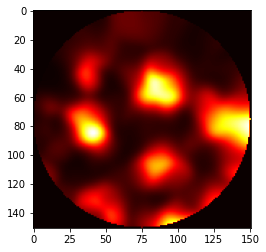

In [12]:
plt.imshow(Tuning_Curves[:,:,3], cmap='hot')

rat 1 M1 indices

In [13]:
M1_indices = [3,8,9,10,12,21,23,25,30,33,35,36,39,40,41,43,44,165,168,181,184,185,186,187,188,191,195,197,201,204,205,208,210,211,213,214,215,216,217,221,222,224]


Getting frames for decoding

In [17]:
#frames = an array of L,L,len(Time)
frames = np.zeros((int(L),int(L),int((len(Time))/3)+1), dtype=float)
print(frames.shape)
for t in range(0,temp,3):#for each time window
    frame = np.zeros((int(L),int(L))) #frame = array of L,L
    for step in range(3):
        for n in range(len(M1_indices)):#for each neuron in M1
            if t< 436877:
                if ST_M1[n,t+step] >0: #if there is a spike in this bin 
                    for spike in range(int(ST_M1[n,t+step])):
                        #get the specific tuning curve for that neuron
                        tc = Tuning_Curves[:,:,n] 
                        frame = frame + tc

    frames[:,:,int(t/3)] = frame

            #for the number of times it spikes
                #add the tuning curve to 

(151, 151, 145627)


10352


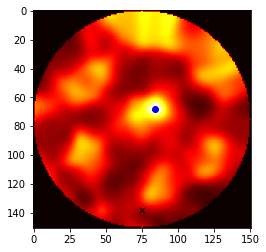

In [35]:
plt.imshow(frames[:,:,25000], cmap='hot')


max_index =  np.argmax(frames[:,:,25000])
print(max_index)
max_idc_x, max_idc_y = np.unravel_index(max_index, (151,151))
plt.plot(max_idc_y,max_idc_x, marker = 'o', color= 'blue')
xpos = x_Pos[int(25000/3)] +75
ypos = y_Pos[int(25000/3)] + 75

plt.plot(ypos,xpos, marker = 'x', color = 'black')


In [79]:
import matplotlib.animation as animation

plt.rcParams['animation.ffmpeg_path'] = '/Users/Niko/Downloads/ffmpeg-2022-08-18-git-48be6616d0-full_build/bin/ffmpeg.exe'

fig, ax = plt.subplots()
heat = ax.imshow(frames[:,:,0], cmap='hot')
rat, = ax.plot([], marker = 'x', color = 'white')
decoded, = ax.plot([], marker = 'o', color= 'blue')

def animate(frame_index):
    #print(frames[:,:,frame_idc].shape)
    frame_idc = frame_index+25000
    heat.set_data((frames[:,:,frame_idc]))
    xpos = x_Pos[int((frame_idc)/3)] +75
    ypos = y_Pos[int((frame_idc)/3)] + 75
    rat.set_data((ypos,xpos))
    max_index =  np.argmax((frames[:,:,frame_idc]))
    #print(max_index)
    max_idc_x, max_idc_y = np.unravel_index(max_index, (151,151))
    decoded.set_data((max_idc_y,max_idc_x))
    return heat, rat, decoded

ani = animation.FuncAnimation(fig, animate, frames=10000, interval=24, blit=False)
try:
    writer = animation.writers['ffmpeg']
except KeyError:
    writer = animation.writers['ffmpeg']
writer = writer(fps=20)
ani.save('save.mp4', writer=writer)
plt.close(fig) 
#rat starts moving at about 2 minutes
#interesting points around 3 minutes and 3:45

(288, 432, 3)


C:\Users\Niko\AppData\Local\Temp\ipykernel_95312\3319070738.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


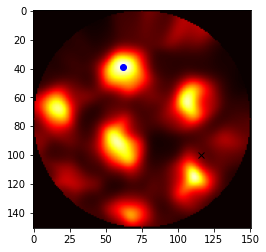

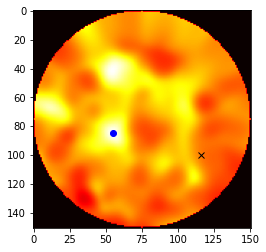

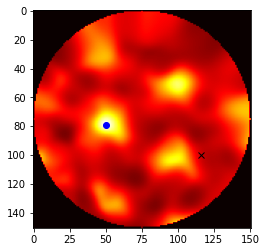

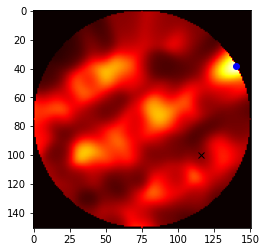

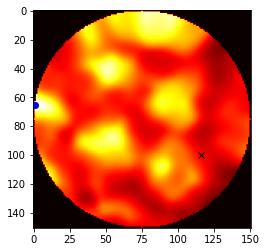

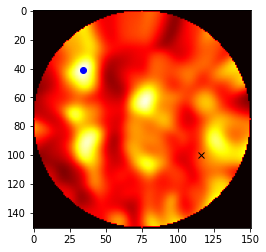

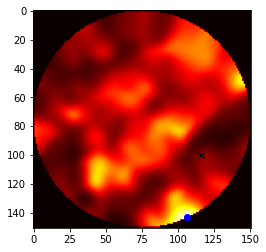

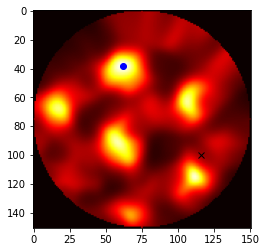

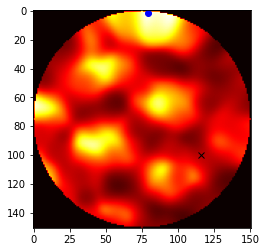

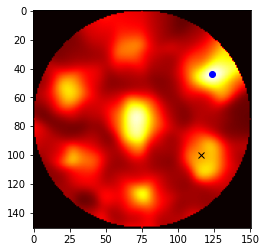

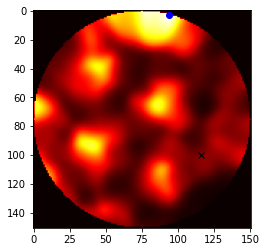

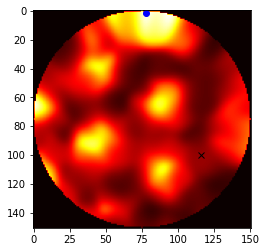

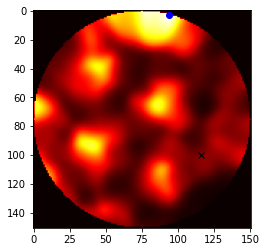

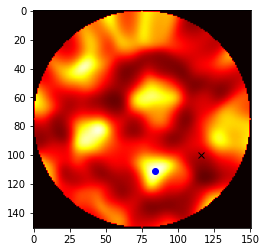

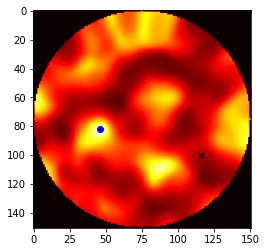

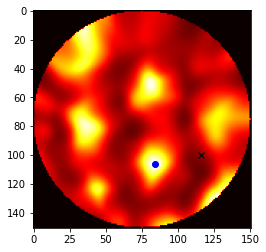

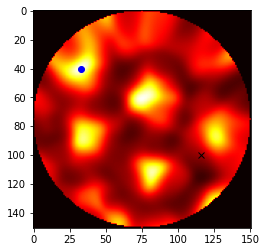

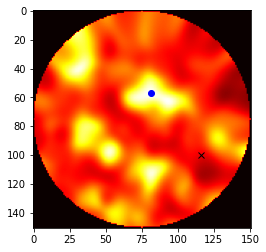

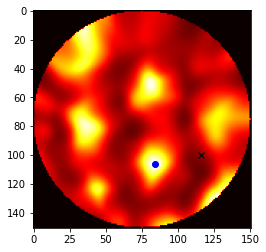

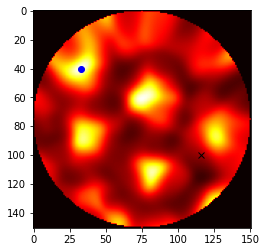

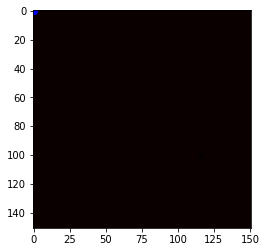

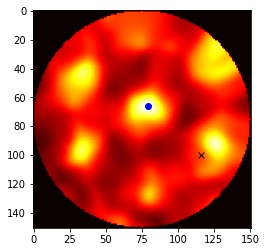

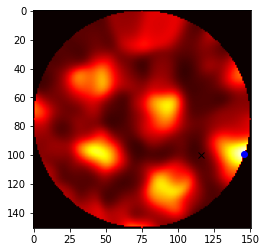

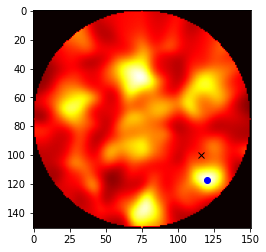

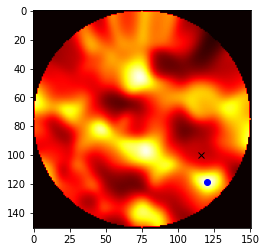

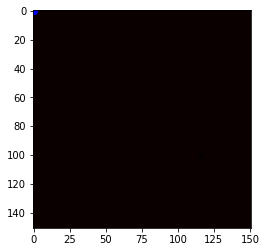

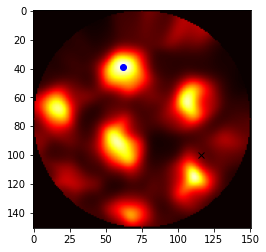

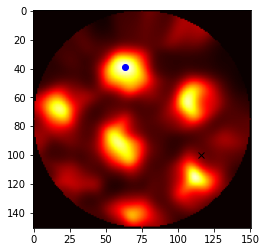

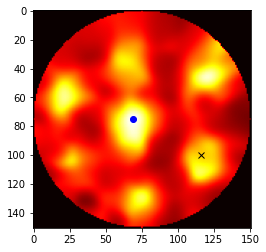

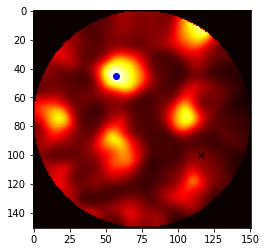

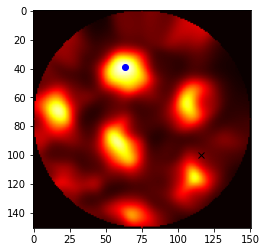

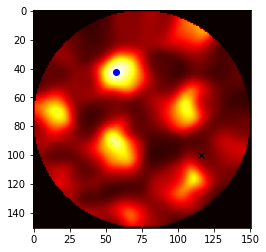

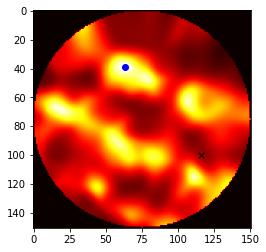

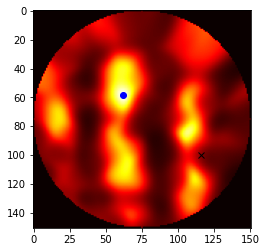

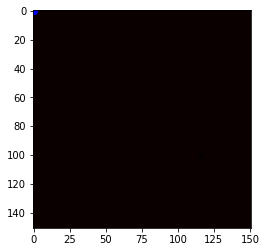

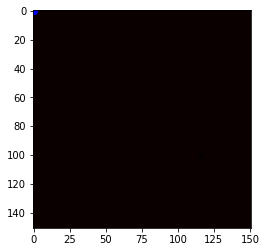

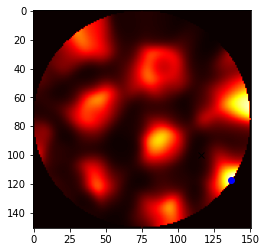

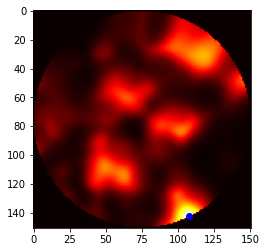

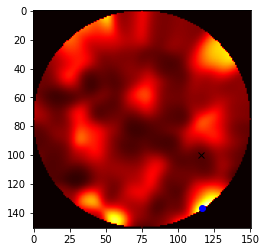

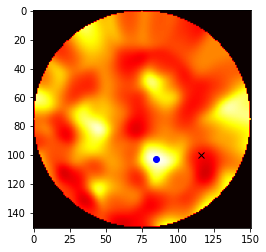

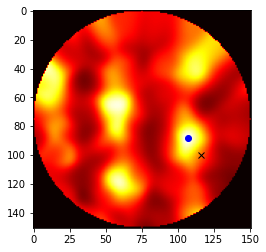

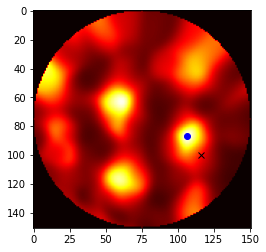

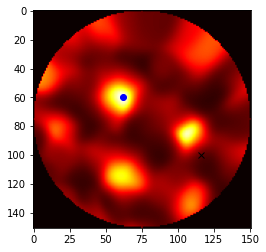

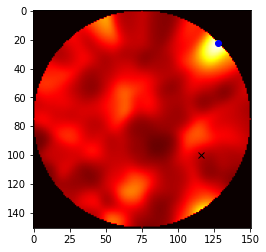

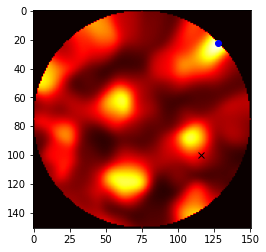

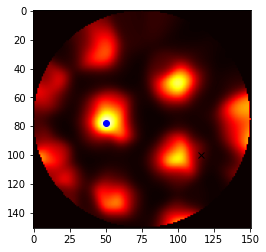

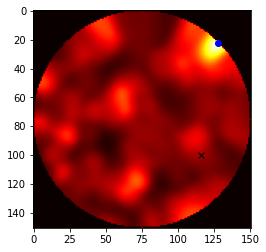

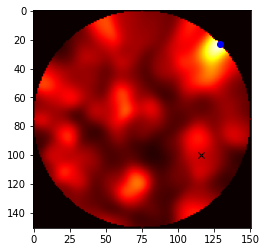

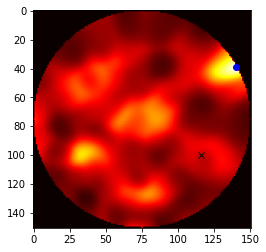

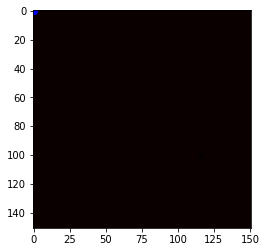

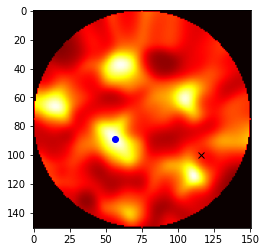

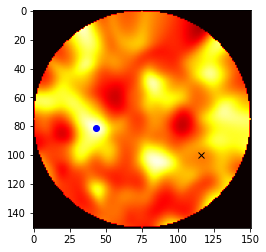

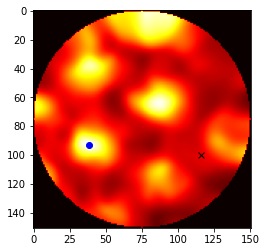

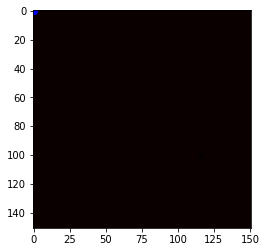

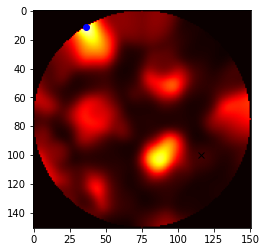

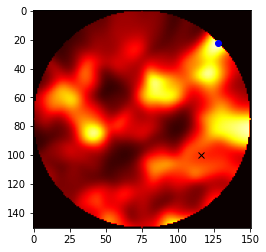

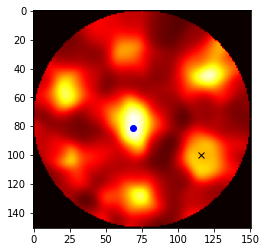

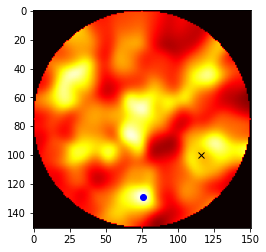

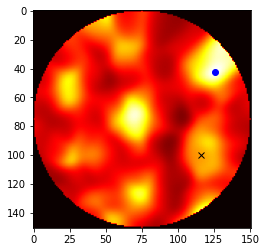

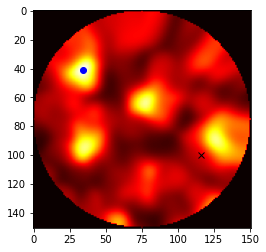

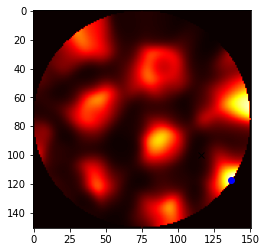

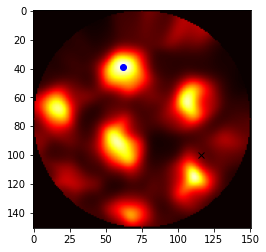

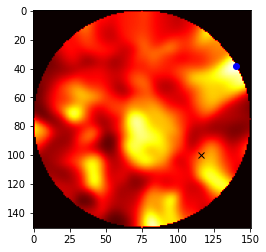

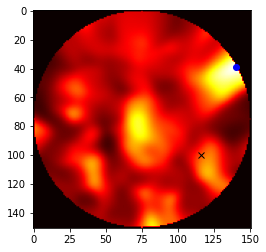

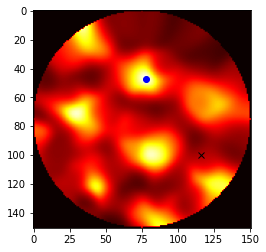

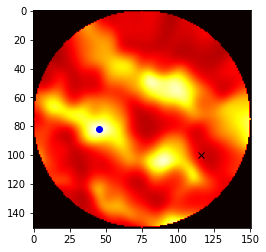

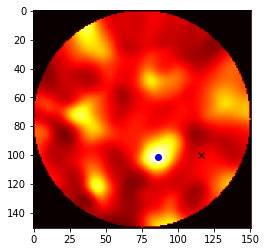

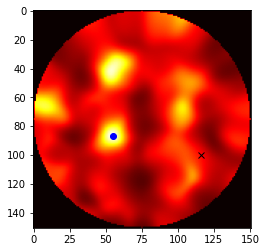

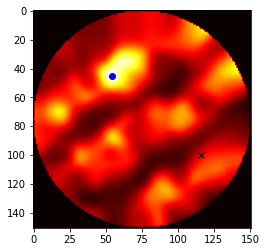

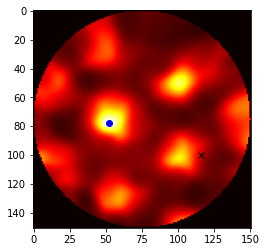

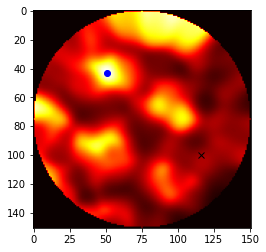

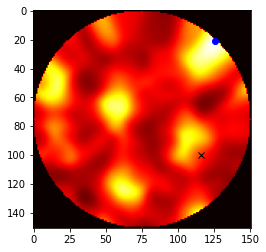

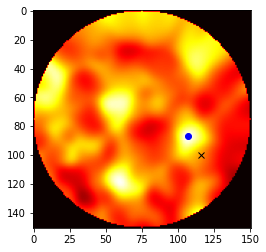

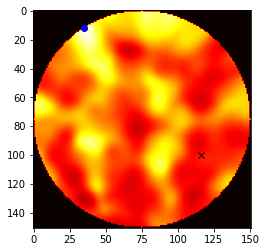

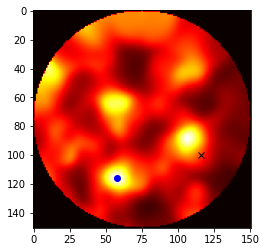

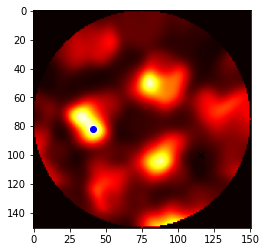

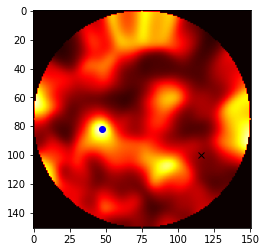

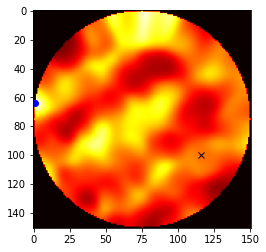

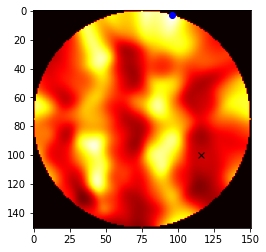

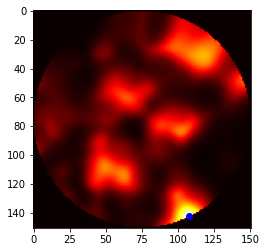

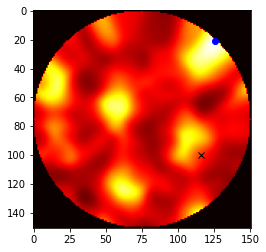

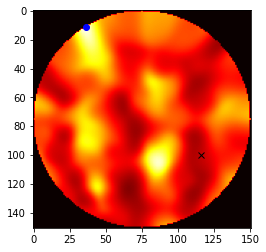

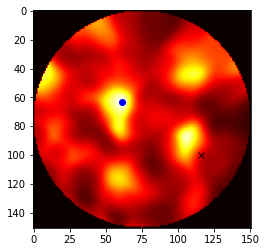

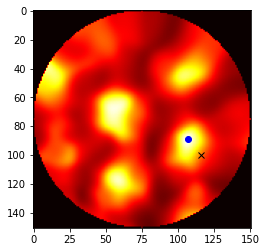

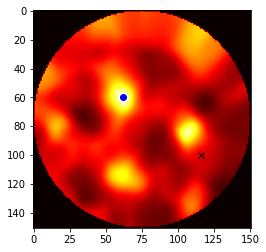

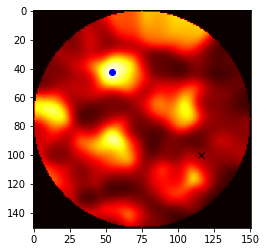

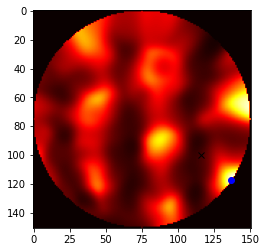

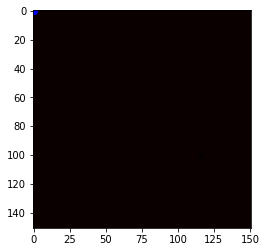

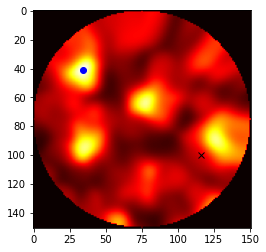

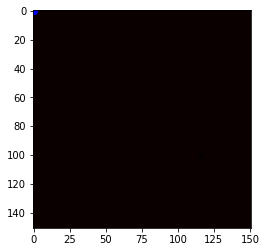

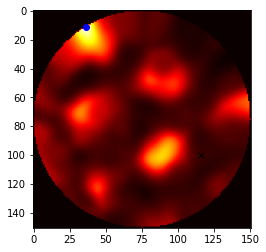

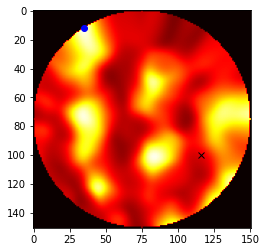

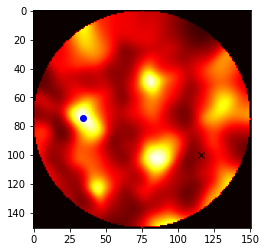

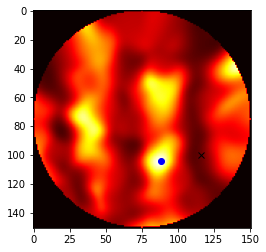

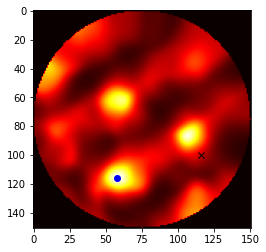

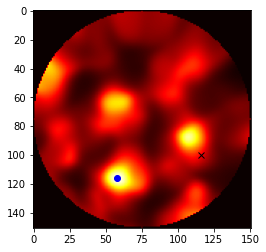

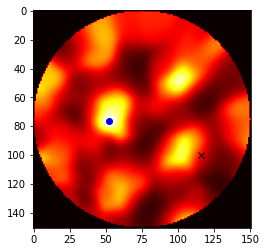

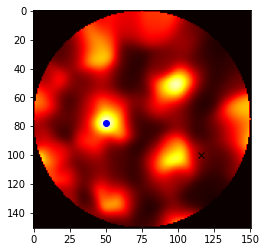

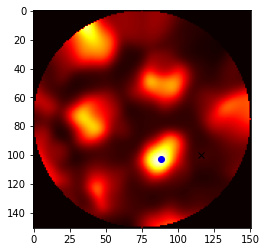

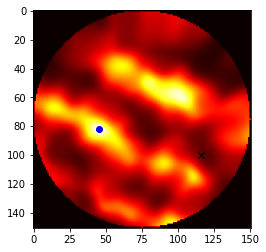

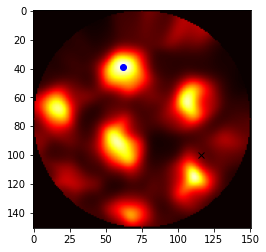

In [51]:
#print(len(frames[0,0,:]))
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def create_frame(frame_idc):
    #print(i)
    fig = plt.figure()
    plt.imshow(frames[:,:,frame_idc], cmap='hot', animated= True)
    max_index =  np.argmax(frames[:,:,frame_idc])
    #print(max_index)
    max_idc_x, max_idc_y = np.unravel_index(max_index, (151,151))
    plt.plot(max_idc_y,max_idc_x, marker = 'o', color= 'blue')
    xpos = x_Pos[int(frame_idc/3)] +75
    ypos = y_Pos[int(frame_idc/3)] + 75

    plt.plot(ypos,xpos, marker = 'x', color = 'black')
    return fig

fig = create_frame(i)

    # put pixel buffer in numpy array
canvas = FigureCanvas(fig)
canvas.draw()
mat = np.array(canvas.renderer._renderer)
mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)
print(mat.shape)

video = cv2.VideoWriter('video.mp4', cv2.VideoWriter_fourcc('A','V','C','1'), 1, (mat.shape[0],mat.shape[1]))

# loop over your images
for i in range(len(frames[0,0,:100])):

    fig = create_frame(i)

    # put pixel buffer in numpy array
    canvas = FigureCanvas(fig)
    canvas.draw()
    #print(i)
    mat = np.array(canvas.renderer._renderer)
    mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)

    # write frame to video
    video.write(mat)

# close video writer
cv2.destroyAllWindows()
video.release()
# plots = []

# fig = plt.figure()
# for i in range(len(frames[0,0,:100])):
#     plots.append(create_frame(i))

# import matplotlib.animation as animation

# ani = animation.ArtistAnimation(fig,plots,interval=50)
#ani.save("movie.mp4")